# 挂载Google Drive

In [ ]:
from google.colab import drive
import os

# 1. 挂载 Drive
drive.mount('/content/drive')

# 2. 设置工作路径 (建议在 Drive 中建一个专门的文件夹，例如 'Colab_Projects')
project_path = '/content/drive/My Drive/Colab Notebooks'

# 3. 切换到该目录
%cd $project_path

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


# 连接Github

In [ ]:
from google.colab import userdata

# 获取 Token
git_token = userdata.get('Colab-GooDrive')
username = "Loogle-Lu"
repo_name = "HydrogenChargingHub"
email = "t13317174496@outlook.com"

# 构建带认证的 URL
git_url = f"https://{git_token}@github.com/{username}/{repo_name}.git"

# 克隆仓库 (如果没有克隆过)
import os
if not os.path.exists(f"{project_path}/{repo_name}"):
    %cd $project_path
    !git clone $git_url
else:
    %cd $project_path/$repo_name
    !git pull

# 配置 Git 身份 (用于 Commit)
!git config --global user.email "$email"
!git config --global user.name "$username"

/content/drive/My Drive/Colab Notebooks/HydrogenChargingHub
Already up to date.


# 安装依赖

In [ ]:
# ==========================================
# Cell 1: 安装依赖
# ==========================================
import sys
import subprocess

print("正在检查并安装依赖环境...")
try:
    import gymnasium
    import stable_baselines3
    import shimmy
except ImportError:
    # 使用 subprocess 替代 !pip，在脚本化运行时更稳定，但在 Colab 中 !pip 也没问题
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gymnasium", "stable_baselines3", "shimmy", "matplotlib", "pandas", "tqdm"])
    print("依赖安装完成！")
else:
    print("依赖已满足，无需安装。")

正在检查并安装依赖环境...
依赖安装完成！


# Import

In [ ]:
# ==========================================
# Cell 2: 导入库与数据读取 (已修改为导入 SAC)
# ==========================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
# [修改点] 导入 SAC 而不是 PPO
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import os
import pickle
import copy
import random
import math
from google.colab import drive
from tqdm.notebook import tqdm

# --- 全局数据容器 ---
PRICE_DATA = None
PV_DATA = None
WD_DATA = None

def load_data():
    global PRICE_DATA, PV_DATA, WD_DATA
    print("正在初始化... 尝试挂载 Google Drive 读取数据...")

    # 挂载 Drive
    if not os.path.exists('/content/drive'):
        try:
            drive.mount('/content/drive')
        except Exception as e:
            print(f"Drive 挂载跳过或失败: {e}")

    data_dir = "/content/drive/MyDrive/RL_environment/Data-file"

    # 1. 价格
    p_path = os.path.join(data_dir, "price_after_MAD_96.pkl")
    if os.path.exists(p_path):
        with open(p_path, 'rb') as f:
            raw = pickle.load(f)
            PRICE_DATA = np.array(raw).flatten()

            # 自动单位修正
            mean_p = np.mean(PRICE_DATA)
            if mean_p > 2.0:
                print(f"⚠️ 检测到价格数值较大 (均值 {mean_p:.2f})，自动除以 100")
                PRICE_DATA = PRICE_DATA / 100.0
            print(f"✅ 价格数据加载成功，均值: ${np.mean(PRICE_DATA):.3f}/kWh")
    else:
        print(f"⚠️ 未找到价格文件 {p_path}，使用合成数据。")
        t = np.linspace(0, 2*np.pi, 96)
        PRICE_DATA = np.clip(0.20 + 0.10*np.sin(t), 0.05, 0.50)

    # 2. PV
    pv_path = os.path.join(data_dir, "pv_power_100.pkl")
    if os.path.exists(pv_path):
        with open(pv_path, 'rb') as f: PV_DATA = pickle.load(f)
        print(f"✅ PV数据加载成功")
    else:
        print("⚠️ 未找到 PV 数据，使用合成数据。")

    # 3. Wind
    wd_path = os.path.join(data_dir, "wd_power_150.pkl")
    if os.path.exists(wd_path):
        with open(wd_path, 'rb') as f: WD_DATA = pickle.load(f)
        print(f"✅ Wind数据加载成功")
    else:
        print("⚠️ 未找到 Wind 数据，使用合成数据。")

# 执行数据加载
load_data()

正在初始化... 尝试挂载 Google Drive 读取数据...
✅ 价格数据加载成功，均值: $0.124/kWh
✅ PV数据加载成功
✅ Wind数据加载成功


# 环境

In [ ]:
# ==========================================
# Cell 3: 物理组件与核心环境定义
# ==========================================

class TwoStageCompressor:
    def __init__(self, max_flow_rate_kg_h=20.0):
        self.max_flow = max_flow_rate_kg_h
        self.eta_c = 0.8
        self.alpha = 1.4
        self.T = 298.15
        self.Cp_coeff = (1.4 / 0.4) * 4115.8 * 298.15 / 1000.0
        self.power_index = (1.4 - 1) / 1.4

    def run(self, action_norm, P_in_bar, P_out_bar, dt_hours):
        target_flow_kg_h = (action_norm + 1) / 2 * self.max_flow

        # 物理限制
        if P_in_bar < 1.05: return 0.0, 0.0

        target_pressure = max(P_out_bar, 20.0)
        P_mid = math.sqrt(P_in_bar * target_pressure)

        try:
            ratio1 = max(1.0, P_mid / P_in_bar)
            w1 = self.Cp_coeff * (pow(ratio1, self.power_index) - 1)
            ratio2 = max(1.0, target_pressure / P_mid)
            w2 = self.Cp_coeff * (pow(ratio2, self.power_index) - 1)
            w_total_specific = (w1 + w2) / self.eta_c
        except:
            return 0.0, 0.0

        power_kw = (target_flow_kg_h * w_total_specific) / 3.6
        mass_moved_kg = target_flow_kg_h * dt_hours

        return power_kw, mass_moved_kg

class HydrogenTank:
    def __init__(self, capacity_kg, max_pressure_bar, init_soc=0.5):
        self.capacity = capacity_kg
        self.max_pressure = max_pressure_bar
        self.level = capacity_kg * init_soc

    def get_pressure(self):
        return self.max_pressure * (self.level / (self.capacity + 1e-6))

    def update(self, flow):
        self.level = np.clip(self.level + flow, 0, self.capacity)
        return self.level

class Electrolyzer:
    def __init__(self, max_power, efficiency=0.02): self.max, self.eff = max_power, efficiency
    def run(self, action):
        p = (action + 1) / 2 * self.max
        return p, p * self.eff

class FuelCell:
    def __init__(self, max_power, efficiency=0.06): self.max, self.eff = max_power, efficiency
    def run(self, action):
        p = (action + 1) / 2 * self.max
        return p, p * self.eff

# --- 核心环境 (V8: 死区激励机制) ---
class HybridChargingHubEnv(gym.Env):
    def __init__(self):
        super(HybridChargingHubEnv, self).__init__()
        self.steps_per_day = 96
        self.days = 5
        self.max_steps = self.steps_per_day * self.days
        self.dt = 0.25

        self.scale_pv = 6.0
        self.scale_wd = 3.0

        self.params = {
            'grid_price': 0.15,
            'ev_fee': 0.5,
            'h2_price': 30.0,
            'pen_i2s': 50.0,
            'pen_miss': 100.0 # 高惩罚，逼迫Agent必须有氢气卖
        }

        self.ely = Electrolyzer(300.0)
        self.fc = FuelCell(100.0)
        self.comp = TwoStageCompressor(max_flow_rate_kg_h=20.0)

        self.lp = HydrogenTank(20.0, 30.0, init_soc=0.5)
        self.hp = HydrogenTank(200.0, 200.0, init_soc=0.5)
        self.init_hp_lvl = self.hp.level

        self.action_space = spaces.Box(-1, 1, (3,), np.float32)
        # 扩展观测维度，加入 "死区" 指示
        self.observation_space = spaces.Box(-5000, 5000, (8,), np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_idx = 0
        self.lp.level = self.lp.capacity * 0.5
        self.hp.level = self.init_hp_lvl
        self.profit = 0
        self._gen_scenario()
        return self._get_obs(), {}

    def _gen_scenario(self):
        len_needed = self.max_steps + 1

        if PRICE_DATA is not None:
            base_price = PRICE_DATA
            if len(base_price) < 96: base_price = np.resize(base_price, 96)
            full_price = np.tile(base_price[:96], self.days + 1)
            self.data_price = full_price[:len_needed]
        else:
            self.data_price = 0.20 * np.ones(len_needed)

        raw_pv, raw_wd = [], []
        for _ in range(self.days + 1):
            if PV_DATA:
                d = np.array(random.choice(PV_DATA)).flatten()
                raw_pv.extend(d[:96])
            else:
                raw_pv.extend(300 * np.maximum(0, np.sin(np.linspace(0,2*np.pi,96))))
            if WD_DATA:
                d = np.array(random.choice(WD_DATA)).flatten()
                raw_wd.extend(d[:96])
            else:
                raw_wd.extend(100 * np.abs(np.sin(np.linspace(0,2*np.pi,96))))

        self.data_pv = np.array(raw_pv[:len_needed]) * self.scale_pv * np.random.uniform(0.9, 1.1, len_needed)
        self.data_wd = np.array(raw_wd[:len_needed]) * self.scale_wd * np.random.uniform(0.8, 1.2, len_needed)

        t = np.linspace(0, 24*self.days, len_needed)
        self.dem_ev = np.clip(200*(np.exp(-((t%24-9)**2)/5)+np.exp(-((t%24-18)**2)/5)), 20, 400)
        self.dem_h2 = np.random.choice([0, 5.0], p=[0.95, 0.05], size=len_needed)

    def _get_obs(self):
        i = self.step_idx
        hp_diff = self.hp.level - self.init_hp_lvl
        return np.array([
            float(self.hp.level), float(self.lp.level), float(self.data_price[i]),
            float(self.dem_h2[i]), float(self.dem_ev[i]),
            float(self.data_pv[i]), float(self.data_wd[i]),
            float(hp_diff)
        ], dtype=np.float32)

    def step(self, action):
        i = self.step_idx
        price = self.data_price[i]

        # 1. Ely -> LP
        p_ely, h2_prod = self.ely.run(action[0])
        self.lp.update(h2_prod * self.dt)

        # 2. Comp -> HP
        p_in = self.lp.get_pressure()
        p_out = self.hp.get_pressure()
        p_comp, h2_moved = self.comp.run(action[1], p_in, p_out, self.dt)

        # Action Shaping: 如果LP没气了还想抽，给惩罚
        invalid_comp_penalty = 0
        if action[1] > -0.9 and p_in < 1.1:
            invalid_comp_penalty = -1.0

        if h2_moved > self.lp.level:
            ratio = self.lp.level / (h2_moved + 1e-6)
            h2_moved = self.lp.level
            p_comp = p_comp * ratio

        self.lp.update(-h2_moved)
        self.hp.update(h2_moved)

        # 3. HP -> Use
        p_fc_tgt, h2_fc_req = self.fc.run(action[2])
        h2_fc_real = min(h2_fc_req * self.dt, self.hp.level)
        p_fc_real = p_fc_tgt * (h2_fc_real / (h2_fc_req * self.dt + 1e-6))

        h2_sales = min(self.dem_h2[i], self.hp.level - h2_fc_real)
        if h2_sales < 0: h2_sales = 0
        self.hp.update(-(h2_fc_real + h2_sales))

        # 4. Profit
        load = self.dem_ev[i] + p_ely + p_comp
        gen = self.data_pv[i] + self.data_wd[i] + p_fc_real
        grid_import = max(0, load - gen)
        ren_consumed = min(load, gen)

        cost = grid_import * price * self.dt
        income = (self.dem_ev[i]*(price + self.params['ev_fee']) + h2_sales*self.params['h2_price']) * self.dt
        profit = income - cost
        self.profit += profit

        # === 5. Reward Engineering ===
        reward = profit * 0.1
        reward -= (self.dem_h2[i] - h2_sales) * self.params['pen_miss']
        reward += invalid_comp_penalty
        reward += 0.02 * p_ely

        soc_diff = self.hp.level - self.init_hp_lvl
        if abs(soc_diff) > 20.0:
            reward -= 0.5 * (abs(soc_diff) - 20.0)

        self.step_idx += 1
        done = self.step_idx >= self.max_steps

        if self.step_idx % 96 == 0:
            reward -= abs(soc_diff) * self.params['pen_i2s']

        info = {
            'profit': profit, 'hp': self.hp.level, 'lp': self.lp.level,
            'grid': grid_import, 'ren': ren_consumed, 'ely_p': p_ely, 'comp_p': p_comp,
            'lp_pressure': p_in
        }
        return self._get_obs(), reward, done, False, info

# 训练和测试

>>> 正在配置硬件加速...
✅ 检测到 GPU: Tesla T4
>>> 已启用 GPU 加速 SAC 训练
>>> 开始训练 (SAC 算法, 200k 步)...


Training (SAC):   0%|          | 0/200000 [00:00<?, ?it/s]

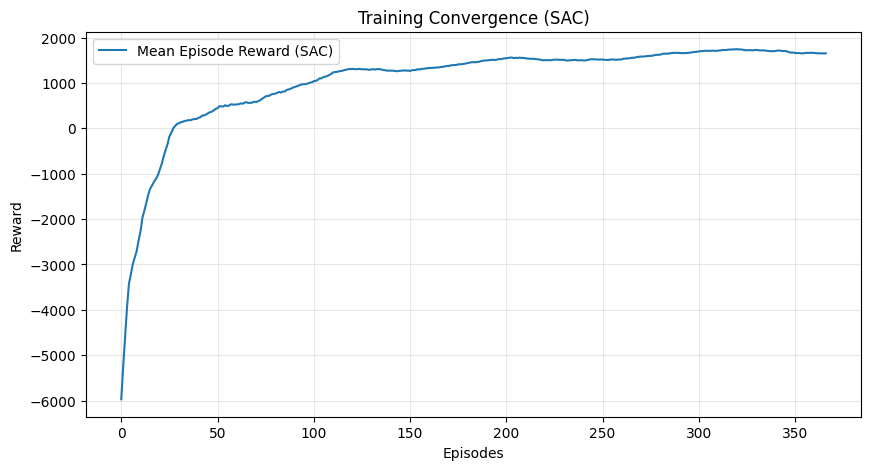


>>> 开始测试...


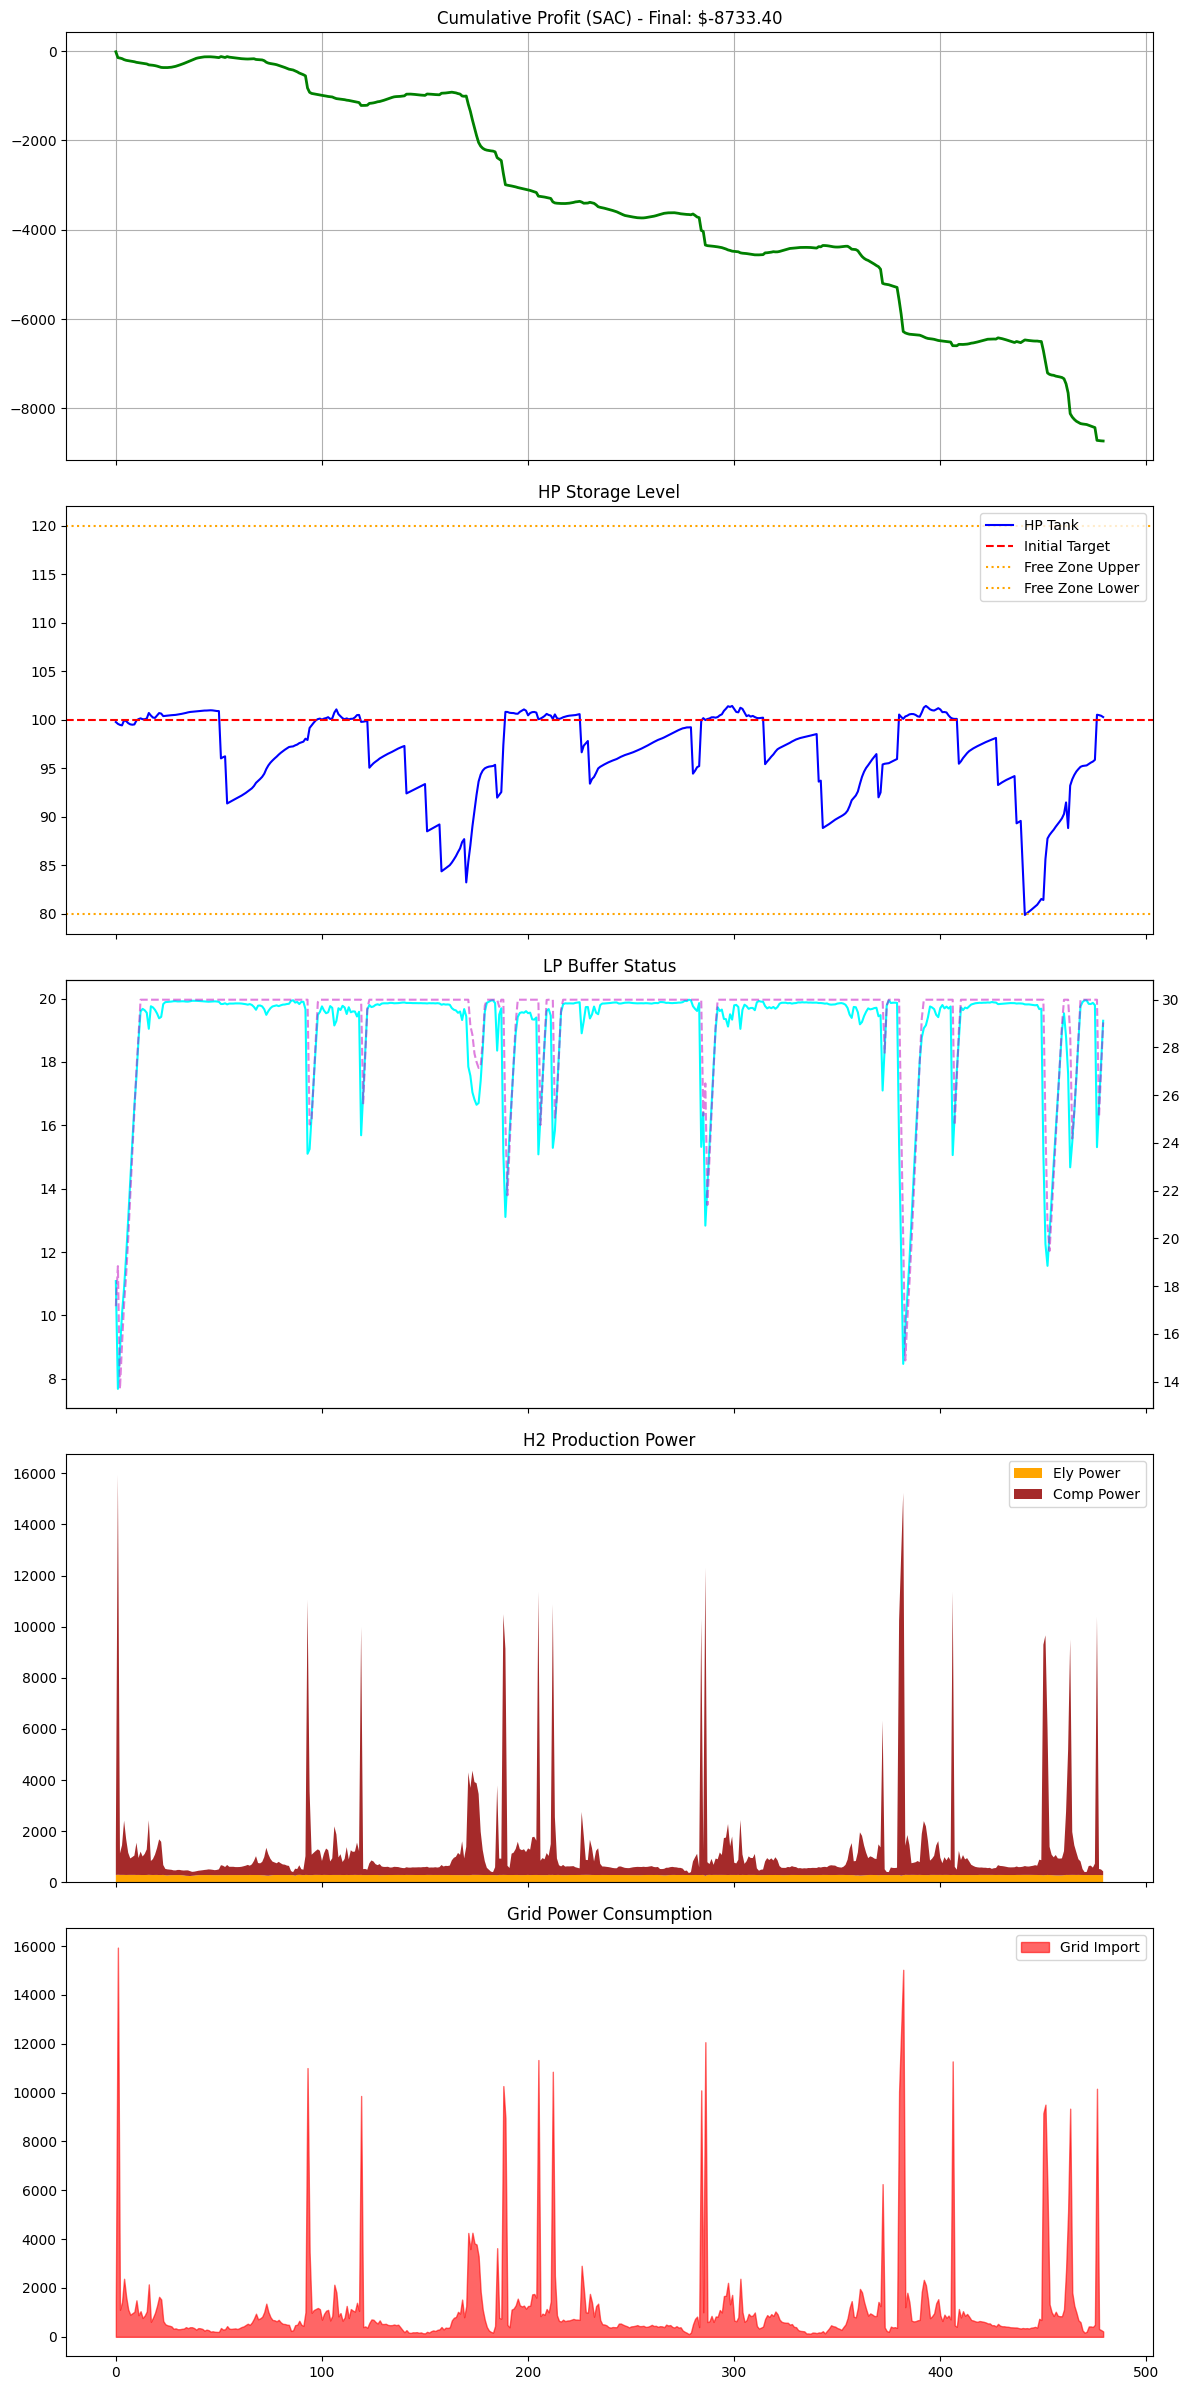

In [ ]:
# ==========================================
# Cell 4: 训练执行与可视化 (已修改为 SAC + GPU 配置)
# ==========================================
import torch # 导入 torch 用于检测 GPU

class TrainingVisualizerCallback(BaseCallback):
    def __init__(self, total_timesteps):
        super().__init__()
        self.pbar = None
        self.total_timesteps = total_timesteps
        self.rewards_history = []

    def _on_training_start(self):
        self.pbar = tqdm(total=self.total_timesteps, desc="Training (SAC)")

    def _on_step(self):
        self.pbar.update(1)
        for info in self.locals['infos']:
            if 'episode' in info:
                ep_rew = info['episode']['r']
                self.rewards_history.append(ep_rew)

                if len(self.rewards_history) % 10 == 0:
                    self.pbar.set_postfix({'Mean Reward': f'{np.mean(self.rewards_history[-20:]):.1f}'})
        return True

    def _on_training_end(self):
        if self.pbar: self.pbar.close()

# 设置训练参数
total_steps = 200000

# 1. 初始化环境
env = DummyVecEnv([lambda: Monitor(HybridChargingHubEnv())])
callback = TrainingVisualizerCallback(total_steps)

# --- 硬件检测 ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f">>> 正在配置硬件加速...")
if device == "cuda":
    print(f"✅ 检测到 GPU: {torch.cuda.get_device_name(0)}")
    print(">>> 已启用 GPU 加速 SAC 训练")
else:
    print("⚠️ 未检测到 GPU，将使用 CPU 训练。")
    print("💡 提示: 建议在 Colab 顶部菜单点击 '修改' -> '笔记本设置' -> 选择 'T4 GPU' 以大幅提升速度。")

print(f">>> 开始训练 (SAC 算法, 200k 步)...")

# 2. 定义模型 (SAC)
# [修改点] SAC 的超参数与 PPO 不同，且指定 device
model = SAC("MlpPolicy", env, verbose=0,
            learning_rate=3e-4,       # SAC 常用学习率
            buffer_size=50000,        # 经验回放池大小 (内存不够可调小)
            learning_starts=1000,     # 先随机探索 1000 步填充 buffer
            batch_size=256,           # 每次从 buffer 采样的数量
            ent_coef='auto',          # 自动调整熵系数 (核心特性)
            gamma=0.99,
            tau=0.005,                # 软更新系数
            device=device)            # [新增] 显式指定设备 (cuda/cpu)

# 3. 开始训练
model.learn(total_timesteps=total_steps, callback=callback)

# 4. 绘制训练曲线
plt.figure(figsize=(10, 5))
rewards = np.array(callback.rewards_history)
if len(rewards) > 0:
    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label='Mean Episode Reward (SAC)')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Training Convergence (SAC)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 5. 测试与可视化
print("\n>>> 开始测试...")
test_env = HybridChargingHubEnv()
obs, _ = test_env.reset()

H = {k: [] for k in ['profit', 'cum_profit', 'hp', 'lp', 'grid', 'ren', 'ely_p', 'comp_p', 'lp_pressure']}

done = False
cum_p = 0
while not done:
    # SAC 输出是确定性的 (deterministic=True) 用于测试
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _, info = test_env.step(action)

    cum_p += info['profit']
    H['cum_profit'].append(cum_p)
    for k in info:
        if k in H: H[k].append(info[k])

# 绘制测试结果 (保持原样)
fig, ax = plt.subplots(5, 1, figsize=(12, 24), sharex=True)
steps = range(len(H['hp']))

ax[0].plot(steps, H['cum_profit'], 'g', lw=2)
ax[0].set_title(f"Cumulative Profit (SAC) - Final: ${H['cum_profit'][-1]:.2f}")
ax[0].grid(True)

ax[1].plot(steps, H['hp'], 'b', label='HP Tank')
ax[1].axhline(100, c='r', ls='--', label='Initial Target')
ax[1].axhline(120, c='orange', ls=':', label='Free Zone Upper')
ax[1].axhline(80, c='orange', ls=':', label='Free Zone Lower')
ax[1].set_title('HP Storage Level')
ax[1].legend()

ax2_twin = ax[2].twinx()
ax[2].plot(steps, H['lp'], 'cyan', label='LP Mass')
ax2_twin.plot(steps, H['lp_pressure'], 'm--', alpha=0.5, label='LP Pressure')
ax[2].set_title('LP Buffer Status')

ax[3].stackplot(steps, H['ely_p'], H['comp_p'], labels=['Ely Power', 'Comp Power'], colors=['orange', 'brown'])
ax[3].set_title('H2 Production Power')
ax[3].legend()

ax[4].fill_between(steps, 0, H['grid'], color='red', alpha=0.6, label='Grid Import')
ax[4].set_title('Grid Power Consumption')
ax[4].legend()

plt.tight_layout()
plt.show()

# 代码清洗

In [ ]:
import json
import os
from google.colab import drive

# ================= 配置区域 =================
# 你的完整文件路径 (直接用你给的这个)
notebook_path = "/content/drive/MyDrive/Colab Notebooks/HydrogenChargingHub/Electrolyzer+Storage+FuelCell+Compressor/SAC.ipynb"

# Git 身份信息 (根据你之前的记录)
user_email = "t13317174496@outlook.com"
user_name = "LoogleLu"
# ===========================================

def fix_and_push():
    # 0. 确保 Drive 挂载
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    if not os.path.exists(notebook_path):
        print(f"❌ 错误：找不到文件！\n请检查路径是否正确: {notebook_path}")
        return

    print(f">>> 正在读取并修复文件: {os.path.basename(notebook_path)}")

    # 1. 读取并修复 JSON
    try:
        with open(notebook_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 标记是否修改过
        modified = False

        # 修复 A: 删除 metadata 中的 widgets
        if 'metadata' in data and 'widgets' in data['metadata']:
            del data['metadata']['widgets']
            print("✅ 已删除 metadata.widgets (主要病灶)")
            modified = True

        # 修复 B: 删除 Cell 输出中的 widget data (次要病灶)
        if 'cells' in data:
            for cell in data['cells']:
                if 'outputs' in cell:
                    for output in cell['outputs']:
                        if 'data' in output and 'application/vnd.jupyter.widget-view+json' in output['data']:
                            del output['data']['application/vnd.jupyter.widget-view+json']
                            modified = True

        if modified:
            with open(notebook_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, indent=1)
            print("✅ 文件修复并保存成功！")
        else:
            print("⚠️ 文件似乎很干净，没有发现 widget 数据。将强制尝试推送。")

    except Exception as e:
        print(f"❌ 读取文件出错: {e}")
        return

# 运行主函数
fix_and_push()

# Git

## Git check

In [ ]:
import os
from google.colab import drive

# ============================
# 配置区域 (请确认无误)
# ============================
# 1. 你的仓库在 Google Drive 的路径
repo_path = '/content/drive/My Drive/Colab Notebooks/HydrogenChargingHub'

# 2. 你的 GitHub 邮箱和用户名 (Git 记录需要)
user_email = "t13317174496@outlook.com"
user_name = "Loogle-Lu"

# 3. 提交信息 (本次修改了什么)
commit_message = "Refactor code structure: split imports, env, and training into cells"

# ============================
# 执行推送逻辑
# ============================

# 1. 挂载 Drive (确保能访问文件)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. 切换工作目录
try:
    os.chdir(repo_path)
    print(f"✅ 已切换到目录: {os.getcwd()}")
except FileNotFoundError:
    print(f"❌ 错误: 找不到路径 {repo_path}。请检查 Drive 挂载或路径拼写。")

# 3. 配置 Git 身份 (Colab 每次重启都会重置这个，所以必须重新配)
os.system(f'git config --global user.email "{user_email}"')
os.system(f'git config --global user.name "{user_name}"')

# 4. Git 提交流程
print("\n>>> 正在检查文件变更...")
!git status


✅ 已切换到目录: /content/drive/My Drive/Colab Notebooks/HydrogenChargingHub

>>> 正在检查文件变更...
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Electrolyzer+Storage+FuelCell+Compressor/SAC.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


## Git push

In [ ]:
print("\n>>> 添加所有变更文件...")
!git add .

print(f"\n>>> 提交变更: {commit_message}")
!git commit -m "{commit_message}"

print("\n>>> 推送到 GitHub...")
# 注意：只要你之前是带 Token clone 的，这里不需要密码
push_result = os.system("git push origin main")

if push_result == 0:
    print("\n✅ 推送成功！请去 GitHub 仓库查看更新。")
else:
    print("\n❌ 推送失败。可能是 Token 过期或网络问题。")
    print("尝试手动运行: !git push origin main 查看详细错误。")


>>> 添加所有变更文件...

>>> 提交变更: Refactor code structure: split imports, env, and training into cells
[main b21a522] Refactor code structure: split imports, env, and training into cells
 1 file changed, 1 insertion(+), 1 deletion(-)

>>> 推送到 GitHub...

✅ 推送成功！请去 GitHub 仓库查看更新。


In [ ]:
import json
import os

# 1. 设置你的文件路径
# 请修改为你实际的 .ipynb 文件名
notebook_path = "/content/drive/MyDrive/Colab Notebooks/HydrogenChargingHub/Electrolyzer+Storage+FuelCell+Compressor/SAC.ipynb"

# 2. 读取文件
with open(notebook_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 3. 删除导致报错的 'widgets' 字段
# 检查 metadata 中是否有 widgets
if 'metadata' in data and 'widgets' in data['metadata']:
    print(f"检测到问题字段: data['metadata']['widgets']")
    del data['metadata']['widgets']
    print("已删除 'widgets' 字段")
else:
    print("未找到 'widgets' 字段，文件可能没有这个问题。")

# 4. 覆盖保存回原文件
with open(notebook_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=1) # indent=1 保持格式美观

print(">>> 修复完成！现在请运行 git add / commit / push 重新推送。")

检测到问题字段: data['metadata']['widgets']
已删除 'widgets' 字段
>>> 修复完成！现在请运行 git add / commit / push 重新推送。
